In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go # 시각화 
import statsmodels.formula.api as smf

import warnings 
warnings.filterwarnings(action = 'ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import NMF 
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy.linalg import svd 
from scipy.sparse.linalg import svds
from factor_analyzer import FactorAnalyzer # 요인분석 install 

# clustering 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

from sklearn.mixture import GaussianMixture

from sklearn.cluster import DBSCAN

from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch 
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering

#KPrototypes ; 범주형, 수치형 둘 다 고려한 알고리즘 install 
from kmodes.kprototypes import KPrototypes

#KModes ; 범주형 데이터를 고려한 클러스터링 알고리즘 
from kmodes.kmodes import KModes

from matplotlib import font_manager, rc 
font_path ='C:\\Windows\\Fonts\\Hancom Gothic Regular.ttf'
font = font_manager.FontProperties(fname=font_path).get_name() 
rc('font', family = font)

# recommentation 

from surprise import Reader

# text 

from konlpy.tag import Okt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

le = LabelEncoder() 
ms = MinMaxScaler() 
ss = StandardScaler() 
rs = RobustScaler() # 이상치에 강한

In [ ]:
data = pd.read_csv('C:/Users/fsecuser507/analysis_data.csv',index_col=0)

In [ ]:
data = data.astype({'AGE' : 'object', 'SEX' : 'object', 'month' : 'object', '접근성' : 'object'})

### **1. 타겟 집단 선택**

**(1) 잡화/물품, 식생활품 선택**

In [ ]:
# 잡화/물품 
thing = data.loc[data['상품대분류'].isin(['담배','생활잡화','신변잡화','취미/레저','의약건강기능']),:]

# 식생활
food =  data.loc[np.logical_not(data['상품대분류'].isin(['담배','생활잡화','신변잡화','취미/레저','의약건강기능'])),:]
  

**(2) 만든 split_df 불러오기**

In [ ]:
split_df = pd.read_csv('C:/Users/fsecuser507/split_df.csv',index_col=0)

**(3) Feature Importance 상위 1순위 변수 기준 데이터 필터링**

In [ ]:


def condition(df, area, spot,age) : 
    
    importance = list(split_df[ (split_df['주변입지'] == spot) & (split_df['AGE'] == age) ]['first'].values) 
    # AGE = 연령 , fist = 상위 첫번째 변수 중요도

    im = importance.pop() 
    
    cond1 = (df['시도명'] == area) # 지역
    cond2 = (df['주변입지'] == spot) # 주변입지 
    cond3 = (df['AGE'] == age) # 연령 
    
    p = input(f'{im} 를 입력해주세요 : ') # 상위 첫번째 변수 중요도에 해당하는 범주 입력받기 
    
    cond4 = (df[im] == p)

    
    # (지역, 주변입지, 연령, 변수 중요도) 조건에 맞는 데이터 프레임 = rd 
    # 입력받은 중요도 상위 변수의 범주에 해당하는 값 = im 
    return df[cond1 & cond2 & cond3 & cond4].drop(['YM_CD','시도명','주변입지','AGE'],axis=1) , im
    
    

In [ ]:
rd,im = condition(food, '서울특별시', '가족주택', 40)

가구생애 를 입력해주세요 : 초중고자녀


In [ ]:
im

'가구생애'

### 2. 클러스터링

In [ ]:
rd.shape

(22773, 13)

In [ ]:
rd.head(3)

,운영점포수,SEX,상품대분류,상품중분류,결제수량,결제금액,결제고객수,month,요일,결제시간,가구생애,단가,접근성
2969714,6685,1,간편식사,도시락,113,520950,98,1,일,00~05,초중고자녀,4610.176991,3
2969715,6685,1,간편식사,주먹밥,166,213932,102,1,일,00~05,초중고자녀,1288.746988,3
2969716,6685,1,간편식사,김밥,103,261712,86,1,일,00~05,초중고자녀,2540.893204,3


In [ ]:
crd = rd.drop([im],axis=1)

In [ ]:
num_cols = list(crd.select_dtypes(['float','int']).columns.values)
cat_cols = list(crd.select_dtypes(['object']).columns.values)
cat_cols 

['SEX', '상품대분류', '상품중분류', 'month', '요일', '결제시간', '접근성']

In [ ]:
crd[num_cols] = ms.fit_transform(crd[num_cols])

In [ ]:
catColumnsPos = [crd.columns.get_loc(col) for col in cat_cols]
print('Categorical Columns : {}'.format(cat_cols)) 
print('Position : {}'.format(catColumnsPos))

Categorical Columns : ['SEX', '상품대분류', '상품중분류', 'month', '요일', '결제시간', '접근성']
Position : [1, 2, 3, 7, 8, 9, 11]


In [ ]:
dfMatrix = crd.to_numpy() 

In [ ]:
cost = [] 
for x in range(2,6) : 
    
        kprototype = KPrototypes(n_jobs = -1, n_clusters = x, init = 'Huang', random_state = 0) 
        
        clusters = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        
        cost.append(kprototype.cost_) 

In [ ]:
df_cost = pd.DataFrame() 
df_cost['clusters'] = range(2,6) 
df_cost['cost'] = cost 

<AxesSubplot:xlabel='clusters', ylabel='cost'>

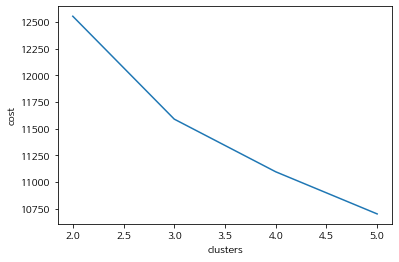

In [ ]:
sns.lineplot(x = 'clusters', y = 'cost', data = df_cost) 

**클러스터링 개수 지정**

In [ ]:
h = input('클러스터 개수를 입력해주세요 : ')
h = int(h)

클러스터 개수를 입력해주세요 : 3


In [ ]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = h, init='Huang', random_state = 0) 
clusters = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos) 

In [ ]:
rd['cluster'] = clusters 

### 3. 추천시스템 

In [ ]:
rd.shape

(22773, 14)

In [ ]:
rd.head(3)

,운영점포수,SEX,상품대분류,상품중분류,결제수량,결제금액,결제고객수,month,요일,결제시간,가구생애,단가,접근성,cluster
5615096,6685,2,의약건강기능,상비약/의약외품,52,76500,25,1,일,00~05,성인자녀,1471.153846,3,2
5615097,6685,2,의약건강기능,건강기능,11,30400,4,1,일,00~05,성인자녀,2763.636364,3,2
5615108,6685,2,신변잡화,세안/위생용품,28,80450,12,1,일,00~05,성인자녀,2873.214286,3,2


In [ ]:
rd.to_csv('C:/Users/fsecuser508/seoul_house_40_chojungo_2.csv')

In [ ]:
rd['cluster'].value_counts()

0    7987
2    7891
1    6895
Name: cluster, dtype: int64

In [ ]:
one = rd[rd['cluster'] == 0] 
two = rd[rd['cluster'] == 1]
three = rd[rd['cluster'] == 2]


In [ ]:
def cos_sim(data,cat_cols) : 

    # 범주형 
    
    # 월별 상품중분류별 결제수량 합계 
    t1 = data.groupby(['상품중분류','month'], as_index = False)['결제수량'].sum()
    t1.rename(columns = {'결제수량' : 'sum'},inplace=True) 
    t1_spread = t1.set_index(['상품중분류','month'])['sum'].unstack(fill_value = 0).reset_index()
    t1_spread.index.name = 'month'
    
    # 월별 상품중분류별 결제고객수 합계     
    t2 = data.groupby(['상품중분류','month'], as_index = False)['결제고객수'].sum()
    t2.rename(columns = {'결제고객수' : 'sum'},inplace=True) 
    t2_spread = t2.set_index(['상품중분류','month'])['sum'].unstack(fill_value = 0).reset_index()
    t2_spread.index.name = 'month'

    # 결제시간별 
    t3 = data.groupby(['상품중분류','결제시간'], as_index = False)['결제수량'].sum()
    t3.rename(columns = {'결제수량' : 'sum'},inplace=True) 
    t3_spread = t3.set_index(['상품중분류','결제시간'])['sum'].unstack(fill_value = 0).reset_index()
    t3_spread.index.name = '결제시간'


    t4 = data.groupby(['상품중분류','결제시간'], as_index = False)['결제고객수'].sum()
    t4.rename(columns = {'결제고객수' : 'sum'},inplace=True) 
    t4_spread = t4.set_index(['상품중분류','결제시간'])['sum'].unstack(fill_value = 0).reset_index()
    t4_spread.index.name = '결제시간'
 
    # 요일별 
    t5 = data.groupby(['상품중분류','요일'], as_index = False)['결제수량'].sum()
    t5.rename(columns = {'결제수량' : 'sum'},inplace=True) 
    t5_spread = t5.set_index(['상품중분류','요일'])['sum'].unstack(fill_value = 0).reset_index()
    t5_spread.index.name = '요일'


    t6 = data.groupby(['상품중분류','요일'], as_index = False)['결제고객수'].sum()
    t6.rename(columns = {'결제고객수' : 'sum'},inplace=True) 
    t6_spread = t6.set_index(['상품중분류','요일'])['sum'].unstack(fill_value = 0).reset_index()
    t6_spread.index.name = '요일'
    
    # 가구생애별 
    t7 = data.groupby(['상품중분류','가구생애'], as_index = False)['결제수량'].sum()
    t7.rename(columns = {'결제수량' : 'sum'},inplace=True) 
    t7_spread = t7.set_index(['상품중분류','가구생애'])['sum'].unstack(fill_value = 0).reset_index()
    t7_spread.index.name = '가구생애'


    t8 = data.groupby(['상품중분류','가구생애'], as_index = False)['결제고객수'].sum()
    t8.rename(columns = {'결제고객수' : 'sum'},inplace=True) 
    t8_spread = t8.set_index(['상품중분류','가구생애'])['sum'].unstack(fill_value = 0).reset_index()
    t8_spread.index.name = '가구생애'
    
    # 접근성별 
    
    t9 = data.groupby(['상품중분류','접근성'], as_index = False)['결제수량'].sum()
    t9.rename(columns = {'결제수량' : 'sum'},inplace=True) 
    t9_spread = t9.set_index(['상품중분류','접근성'])['sum'].unstack(fill_value = 0).reset_index()
    t9_spread.index.name = '접근성'

    t10 = data.groupby(['상품중분류','접근성'], as_index = False)['결제고객수'].sum()
    t10.rename(columns = {'결제고객수' : 'sum'},inplace=True) 
    t10_spread = t10.set_index(['상품중분류','접근성'])['sum'].unstack(fill_value = 0).reset_index()
    t10_spread.index.name = '접근성'
    
    # 성별별
    
    t11 = data.groupby(['상품중분류','SEX'], as_index = False)['결제수량'].sum()
    t11.rename(columns = {'결제수량' : 'sum'},inplace=True) 
    t11_spread = t11.set_index(['상품중분류','SEX'])['sum'].unstack(fill_value = 0).reset_index()
    t11_spread.index.name = 'SEX'

    t12 = data.groupby(['상품중분류','SEX'], as_index = False)['결제고객수'].sum()
    t12.rename(columns = {'결제고객수' : 'sum'},inplace=True) 
    t12_spread = t12.set_index(['상품중분류','SEX'])['sum'].unstack(fill_value = 0).reset_index()
    t12_spread.index.name = 'SEX'
    
    list_df = []
    
    for q in [t1_spread, t2_spread, t3_spread,t4_spread,t5_spread,t6_spread,t7_spread,t8_spread,t9_spread, t10_spread,t11_spread, t12_spread] : 
        
        if q.index.name in cat_cols :
            
            list_df.append(q)
        
        
        
    
    temp_merge = list_df[0].merge(list_df[1], on ='상품중분류',how='left',suffixes = ('_결제수량','_결제고객수')) 
    
    for k in list_df[2:] : 
        
        c_merge = temp_merge.merge(k, on = '상품중분류', how = 'left',suffixes = ('_결제수량','_결제고객수')) 
        temp_merge = c_merge 
    
    c_merge = c_merge.reset_index() 
    c_merge = c_merge.set_index('상품중분류') 
    
        
    #c_merge['평균단가'] = data.groupby(['상품중분류']).agg({'단가' : 'mean'})
    #c_merge['평균경쟁점포수'] = data.groupby(['상품중분류']).agg({'운영점포수' : 'mean'})

    
    item_based_collabor_final = cosine_similarity(c_merge) 
    item_based_collabor_final = pd.DataFrame(data = item_based_collabor_final, index=c_merge.index, columns = c_merge.index)
    
    return item_based_collabor_final
    

In [ ]:
def recom(thing,data, cat) : 
    return cos_sim(data,cat)[thing].sort_values(ascending=False)[:8]

**군집별 동일상품에 대한 추천 결과**


In [ ]:
rd

,운영점포수,SEX,상품대분류,상품중분류,결제수량,결제금액,결제고객수,month,요일,결제시간,가구생애,단가,접근성,cluster
2969714,6685,1,간편식사,도시락,113,520950,98,1,일,00~05,초중고자녀,4610.176991,3,0
2969715,6685,1,간편식사,주먹밥,166,213932,102,1,일,00~05,초중고자녀,1288.746988,3,0
2969716,6685,1,간편식사,김밥,103,261712,86,1,일,00~05,초중고자녀,2540.893204,3,0
2969717,6685,1,간편식사,샌드위치/햄버거,170,414020,133,1,일,00~05,초중고자녀,2435.411765,3,0
2969718,6685,1,간편식사,간편식파스타/샐러드,3,13100,3,1,일,00~05,초중고자녀,4366.666667,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5613618,5648,1,음료,얼음/아이스드링크,303,272331,135,11,수,18~23,초중고자녀,898.782178,2,2
5613619,5648,1,음료,유제품,1624,2404220,865,11,수,18~23,초중고자녀,1480.431034,2,2
5613620,5648,1,주류,맥주,5979,15606140,1664,11,수,18~23,초중고자녀,2610.158889,2,1
5613621,5648,1,주류,소주/전통주,2688,5558290,1381,11,수,18~23,초중고자녀,2067.816220,2,1


In [ ]:
recom('와인/양주', one, cat_cols) 

### 군집1 
# 평균 결제 제품 단가가 2번째로 높음
# 편의점 접근 편리성 지수 : 3 
# 저녁시간대 결제량 많음 
# 음료 > 과자류 > 가공식품류 

# 식재료반찬, 안주류, 디저트 , 비스켓/스낵/시리얼



상품중분류
와인/양주           1.000000
식재료/반찬          0.985818
안주류             0.983920
디저트             0.983411
가공식사제품          0.982961
탄산음료            0.980605
비스켓/스낵/시리얼      0.978055
튀김/베이커리/군고구마    0.976947
Name: 와인/양주, dtype: float64

In [ ]:
recom('와인/양주', two, cat_cols) 

### 군집2 
# 평균 결제 제품 단가가 가장 높음
# 오후 시간대 결제량이 많음 
# 주류 > 디저트류 > 음료 > 아이스크림 

# 디저트, 식재료/반찬, 과일/채소 

상품중분류
와인/양주           1.000000
디저트             0.983277
식재료/반찬          0.979482
과일/채소           0.977345
튀김/베이커리/군고구마    0.972305
샌드위치/햄버거        0.971059
도시락             0.967415
빵/떡             0.964959
Name: 와인/양주, dtype: float64

In [ ]:
recom('와인/양주', three, cat_cols) 


### 군집3
# 평균 결제 제품 단가가 가장 낮음
# 저녁시간대 결제량 많음 
# 주류 > 음료 > 과자류 > 가공식품 



# 식재료/반찬, 가공식사제품, 디저트 ,면류 

상품중분류
와인/양주           1.000000
식재료/반찬          0.992507
가공식사제품          0.988449
디저트             0.985921
안주류             0.980223
빵/떡             0.978678
면류              0.978044
튀김/베이커리/군고구마    0.977792
Name: 와인/양주, dtype: float64